Predict and visualize images/video with overlay

In [11]:
import sys
from pathlib import Path

import cv2
import PIL.Image
import torch
from torch import Tensor
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms.v2 import functional as TF
from tqdm import tqdm

sys.path.append(str(Path("..").resolve()))
from src.pixseg.datasets import *
from src.pixseg.models import *
from src.pixseg.pipeline import TestTimeAugmentations, inference_with_augmentations
from src.pixseg.utils.transform import SegmentationAugment, SegmentationTransform
from src.pixseg.utils.visual import combine_images, draw_mask_on_image

In [14]:
import importlib
from src.pixseg.utils import visual
importlib.reload(visual)

<module 'src.pixseg.utils.visual' from 'C:\\Users\\cyrus.kfcheung\\_Workspace\\pixseg\\src\\pixseg\\utils\\visual.py'>

In [2]:
# source https://www.pexels.com/video/vehicle-on-highway-with-dash-cam-4608285/
VIDEO_PATH = Path(r"..\assets\4608285-uhd_3840_2160_24fps.mp4")

In [3]:
metadata = resolve_metadata("Cityscapes")
transforms = SegmentationTransform(mask_fill=metadata.ignore_index)
augment = SegmentationAugment(mask_fill=metadata.ignore_index)
model = sfnet_resnet101(weights=SFNet_ResNet101_Weights.CITYSCAPES)
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 4
frame_size = (1280, 720)
ttas = TestTimeAugmentations(
    (0.75, 1, 1.25), (False, True), (False,), (-15, 0, 15), iter_product=True
)

In [4]:
def generate_frames(capture: cv2.VideoCapture):
    while capture.isOpened():
        ret, frame = capture.read()
        if not ret:
            break
        yield frame


def video_to_tensor(video_file: str, size: tuple[int, int] | None = None) -> Tensor:
    """
    Args:
        size: tuple of (width, height)

    Return:
        video tensor of (num_frames, height, width, channels)
    """
    capture = cv2.VideoCapture(video_file)
    if not capture.isOpened():
        raise RuntimeError("Error opening video file")

    frames: list[Tensor] = []
    num_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))  # reference only
    frame_loader = tqdm(generate_frames(capture), "Load video", num_frames)
    for frame in frame_loader:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if size is not None:
            frame = cv2.resize(frame, size)
        frame_tensor = torch.from_numpy(frame)
        frames.append(frame_tensor)

    capture.release()
    video_tensor = torch.stack(frames)
    return video_tensor


def tensor_to_video(frames: Tensor, output_file: str, fps=24):
    num_frames, channels, height, width = frames.shape
    video_writer = cv2.VideoWriter(output_file, 0, fps, (width, height))

    frame_loader = tqdm(frames, "Write video", num_frames)
    for frame in frame_loader:
        # (C, H, W) -> (H, W, C)
        frame = frame.permute(1, 2, 0)
        frame = TF.to_dtype(frame, torch.uint8, scale=True)
        frame_np = cv2.cvtColor(frame.numpy(force=True), cv2.COLOR_RGB2BGR)
        video_writer.write(frame_np)

    video_writer.release()

In [5]:
frames = video_to_tensor(str(VIDEO_PATH), frame_size)
frames = frames.permute(0, 3, 1, 2)  # (F, H, W, C) -> (F, C, H, W)
print(frames.shape)

Load video: 100%|██████████| 714/714 [00:24<00:00, 28.79it/s]


torch.Size([714, 3, 720, 1280])


In [6]:
model.eval().to(device)
dataset = TensorDataset(frames)
data_loader = DataLoader(dataset, batch_size=batch_size)

batch_preds: list[Tensor] = []
with torch.no_grad():
    for (data,) in tqdm(data_loader):
        data = transforms(data)[0].to(device)
        augmented_logits = inference_with_augmentations(model, data, ttas)
        logits = torch.mean(augmented_logits, dim=0)
        batch_preds.append(logits.argmax(1).cpu())
preds = torch.cat(batch_preds, dim=0)
print(frames.shape, preds.shape)

100%|██████████| 179/179 [06:13<00:00,  2.09s/it]


torch.Size([714, 3, 720, 1280]) torch.Size([714, 720, 1280])


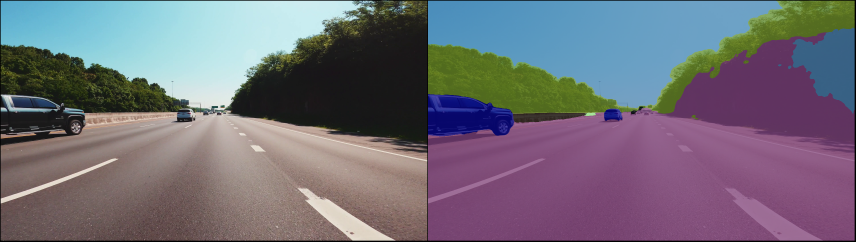

In [26]:
index = 5
colors = metadata.colors
pred_overlay = visual.draw_mask_on_image(frames[index], preds[index], colors, alpha=0.7)
snapshot = combine_images([frames[index], pred_overlay])
snapshot_pil: PIL.Image.Image = TF.to_pil_image(snapshot)
display(snapshot_pil.reduce(3))

In [29]:
output_frames: list[Tensor] = []
for frame, pred in tqdm(zip(frames, preds), "Draw mask", frames.size(0)):
    overlay = visual.draw_mask_on_image(frame, pred, colors, alpha=0.7)
    output_frame = combine_images([frame, overlay], nrow=1)
    output_frames.append(output_frame)
output_video = torch.stack(output_frames)
output_path = VIDEO_PATH.parent / f"{VIDEO_PATH.stem}-parse.avi"
tensor_to_video(output_video, str(output_path))

Write video: 100%|██████████| 714/714 [00:09<00:00, 75.94it/s]
